# CSCE 623 Homework Assignment 5

### Student Name:  <font color="red">TODD, MICHAEL </font>

### Date: <font color="red">May 18, 2022</font>

### Solving Common Problems

Instructions:
* Review all provided code before starting your work - this instructor has provided hints and tips throughout the code
* This assignment is composed of 3 parts (3 case studies)
    * Each part is designed to be a standalone snippet of a machine learning activity which contains flaws
    * Your goal is to identify the flaw by performing steps required to diagnose the flaws
    
* In each case, you will complete several steps
    * CODE CELL (diagnostics): Write code to diagnose the problem and produce evidence of the issue (e.g. print statements, tables, and graphs).  
    (IMPORTANT - Even if you can see the flaw directly in the provided code you must include code here to demonstrate the flaw to show evidence of it - failing to do so will result in not achieving full score on the assignment.)
    * MARKDOWN CELL: Describe the problem and how to solve it in a markdown cell (English text)
    * CODE CELL (solution): Solve the issues so the ML task works properly
    
* Additional Requirements / Considerations
    * While you may inspect the performance on the test set during diagnosis, you should not use the test set to fix the issue.  All decisionmaking (e.g. hyperparameter selection) should be conducted on the non-test set.
    * Some form of validation such as validation, crossvalidation or LOOCV should be used for hyperparameter tuning (dont just tune on the training set)
    * Ensure your choices for hyperparameter decisions and rationale for using them are displayed/explained in code and/or markdown cells
    * Make decisions algorithmically (avoid hardcoding values)

* Remember to restart the kernel and rerun all cells before submitting the assignment
* Submit only the Jupyter Notebook (.ipynb) file - do not submit the datasets.

In [96]:
# Note... not all of these are used...

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import copy

from math import factorial

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate,  cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer, average_precision_score, recall_score, accuracy_score, precision_score, confusion_matrix

from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, RocCurveDisplay 


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.feature_selection import SequentialFeatureSelector

%matplotlib inline
plt.style.use('seaborn-white')

from IPython.display import Markdown as md

import warnings
#warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

## OPTIONAL STUDENT CODING: If you need any imports, code them below

In [97]:
######### ------- EXTRA STUDENT IMPORTS ------------


######### ------- END STUDENT IMPORTS ------------

In [98]:
#helper functions provided by instructor

def data_explore(df):
    

    display(md('Data Statistics:'))
    display(df.describe())
    display(md('Class 0 Statistics:'))
    display(df.loc[df.Class==0,:].describe())
    display(md('Class 1 Statistics:'))
    display(df.loc[df.Class==1,:].describe())
    display(md('Covariance of Class 0:'))
    display(df.loc[df.Class==0,['X1','X2']].cov())
    display(md('Covariance of Class 1:'))
    display(df.loc[df.Class==1,['X1','X2']].cov())
    sns.pairplot(df, hue="Class", height=5)
    df.loc[df.Class==0,:].hist(grid=False, layout=(1,3), figsize=(12,4));
    df.loc[df.Class==1,:].hist(grid=False, layout=(1,3), figsize=(12,4));
    

    
def predict_probs(models, X):
    """ Returns a dictionary of predicted proability vectors using models stored in the input dictionary 'models' on the feature data 'X'
    params:  
    models - a dictionary of fitted classification models with key equal to the name of the model
    X - the values of a dataset obtained"""
    predicts = {}
    
    for key, model in models.items():
        predicts[key] = model.predict_proba(X)
    return predicts    

------------------------------------
# CASE 1

The aspiring machine learning novice is trying to build a simple logistic regression classifier to fit a 2-feature, 2 class dataset, but the outcome is not as expected... you must rescue them from their uncertain fate!

------------------------------------

### Case 1 - Load data & explore:

Data Statistics:

,X1,X2,Class
count,1000.000000,1000.000000,1000.000000
mean,0.284649,-0.007965,0.255000
std,0.639555,0.502198,0.436079
min,-1.301051,-1.474840,0.000000
25%,-0.160430,-0.352626,0.000000
50%,0.224621,-0.027862,0.000000
75%,0.702444,0.346045,1.000000
max,2.188683,1.765224,1.000000


Class 0 Statistics:

,X1,X2,Class
count,745.000000,745.000000,745.0
mean,0.038584,-0.025403,0.0
std,0.476093,0.500715,0.0
min,-1.301051,-1.474840,0.0
25%,-0.273378,-0.358700,0.0
50%,0.036290,-0.029248,0.0
75%,0.347024,0.318305,0.0
max,1.481068,1.765224,0.0


Class 1 Statistics:

,X1,X2,Class
count,255.000000,255.000000,255.0
mean,1.003544,0.042983,1.0
std,0.498380,0.504038,0.0
min,-0.214128,-1.292231,1.0
25%,0.647435,-0.325041,1.0
50%,0.995023,-0.011687,1.0
75%,1.377932,0.416004,1.0
max,2.188683,1.325965,1.0


Covariance of Class 0:

,X1,X2
X1,0.226664,-0.009245
X2,-0.009245,0.250716


Covariance of Class 1:

,X1,X2
X1,0.248383,0.019030
X2,0.019030,0.254054


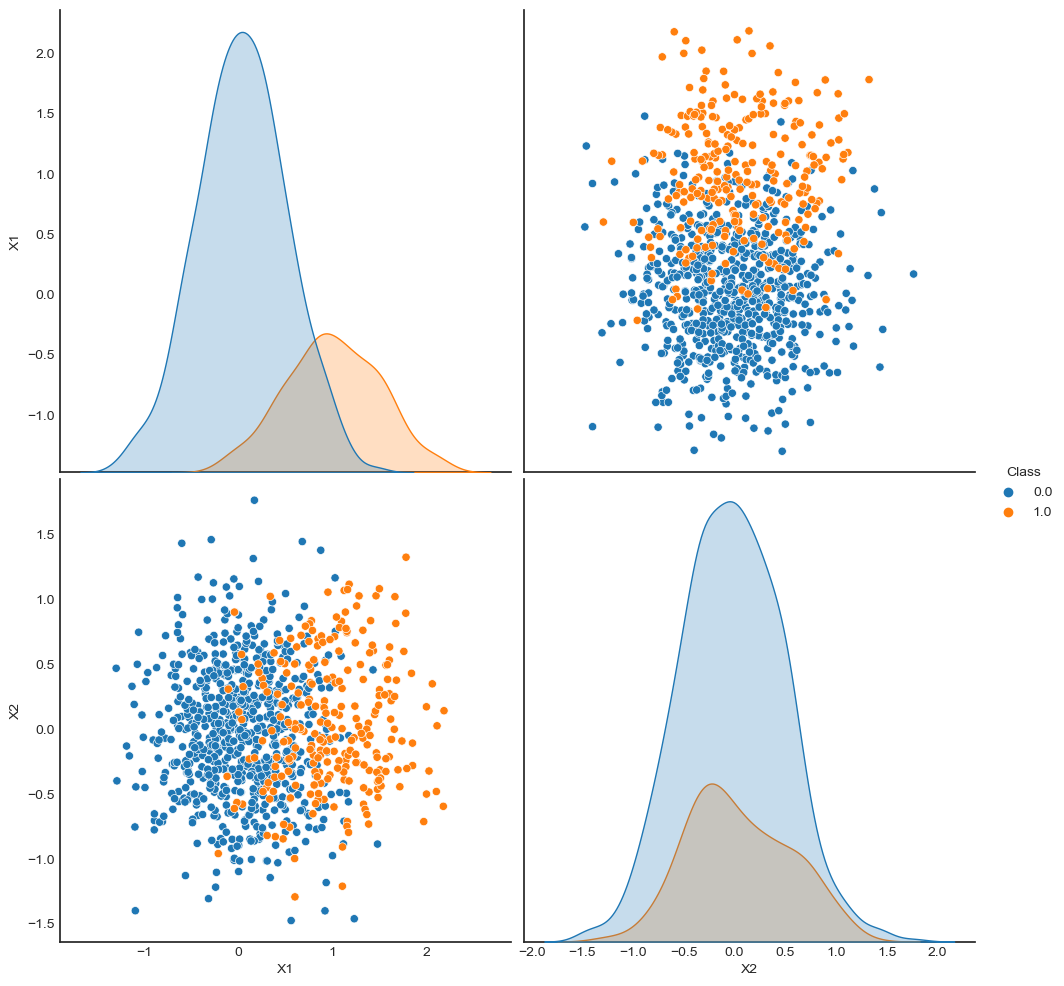

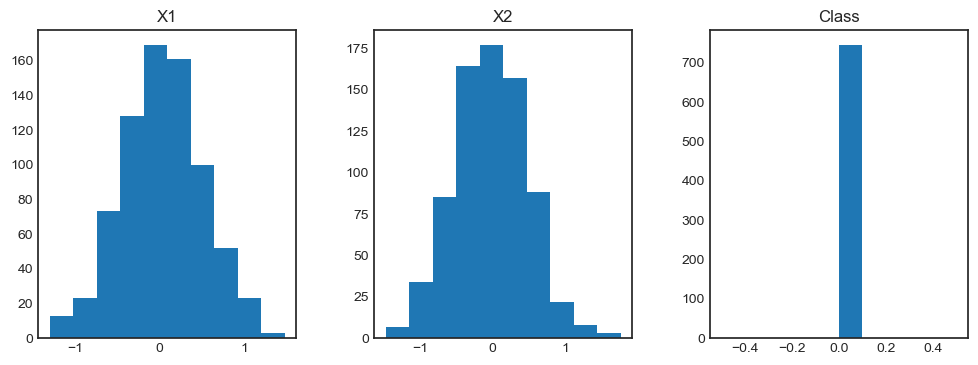

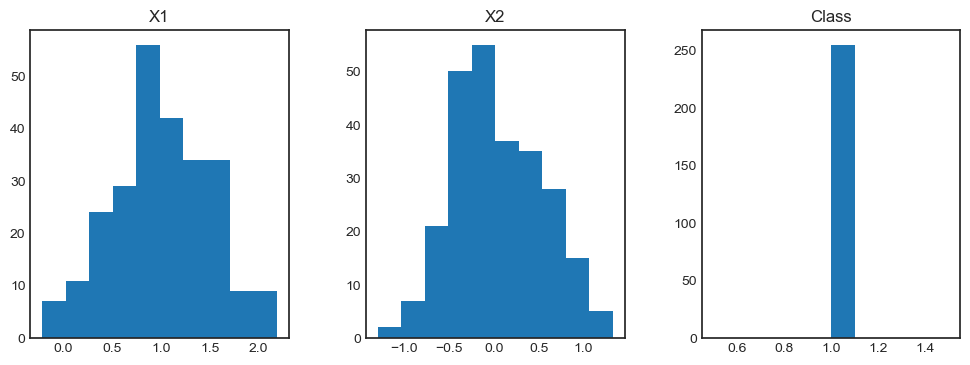

In [99]:
#load dataset
# c1_df = pd.read_csv("c1_data.csv")
c1_df = pd.read_csv('c1_data.csv', header=0, names=['X1','X2','Class'], index_col=0)



#visualize/explore the dataset
data_explore(c1_df)


    



### Case 1 - Split test & non-test, fit a model and evaluate performance

In [100]:
#split into test & training
tngfrac = 0.75  # 25 percent of data used for test, rest for non-test
tngqty = np.ceil(tngfrac*len(c1_df)).astype(int)
c1_non_test_df, c1_test_df= c1_df[:tngqty], c1_df[tngqty:]
 

#fit a model
c1_model = LogisticRegression()
feature_cols = ['X1','X2']
c1_model.fit(c1_non_test_df[feature_cols],c1_non_test_df.Class)

#check performance on non-test set
non_test_cv_scores = cross_val_score(c1_model, c1_non_test_df[feature_cols], c1_non_test_df.Class, cv=5)
print("\n\n\nNon-test mean accuracy from 5-fold CV", np.mean(non_test_cv_scores))

#eval performance on test set
yhat = c1_model.predict(c1_test_df[feature_cols])
test_score = c1_model.score(c1_test_df[feature_cols], c1_test_df['Class'])
print("\nTest set accuracy:", test_score)
print("\n\n")




Non-test mean accuracy from 5-fold CV 0.9933333333333334

Test set accuracy: 0.0





### C1 ISSUE & TASK:

The 5-fold crossval performance of a model on the non-training data looks very good, but the test set performance is bad.  

Your job is to figure out why.   In the areas below, complete the following steps

1.  Use the student code area below to diagnose the problem (use any tools you have learned in the class to do this).  Once you figure out what the problem is, make sure it is clearly presented using code to visualize/print evidence of the problem
2.  Use the markdown area after the code cell to describe the problem
3.  Solve the problem in the designated code cell after the markdown cell by copying the above cells and fixing errors to resolve the performance gap.   

Hint:  Your CV performance and your test performance should be similar and both should be better than chance on this dataset.

## Case 1 Diagnostics to discover the problem (STUDENT CODE REQUIRED)

In [103]:
# CASE 1 DIAGNOSTICS

# --------- START STUDENT CODE -------------

# The data was not split with stratified classes, as shown in this print of c1_test. 
# The manual splitting in the following line of code must be changed.
# c1_non_test_df, c1_test_df= c1_df[:tngqty], c1_df[tngqty:]


# There should be a similar distibution of 1 and 0s as seen in non test data.
print(f"Class 1 in non test: { c1_non_test_df[c1_non_test_df['Class']==1].shape[0] }")
print(f"Class 0 in non test: { c1_non_test_df[c1_non_test_df['Class']==0].shape[0] }")
print(f"Class 1 in TEST: { c1_test_df[c1_test_df['Class']==1].shape[0] }")
print(f"Class 0 in TEST: { c1_test_df[c1_test_df['Class']==0].shape[0] }")

c1_non_test_df.describe()

# classes are unbalanced, need to account for this during fitting using class_weight='balanced' or providing class weights.

# --------- END STUDENT CODE -------------




Class 1 in non test: 191
Class 0 in non test: 559
Class 1 in TEST: 64
Class 0 in TEST: 186


,X1,X2,Class
count,750.000000,750.000000,750.000000
mean,0.290506,-0.019577,0.254667
std,0.644898,0.509048,0.435964
min,-1.301051,-1.474840,0.000000
25%,-0.161341,-0.355430,0.000000
50%,0.217839,-0.049169,0.000000
75%,0.748062,0.335881,1.000000
max,2.181277,1.446615,1.000000


## CASE 1 Explanation and plan for solution (STUDENT MARKDOWN REQUIRED)

In the markdown cell below, describe the problem/mistake the novice made and describe your plan for fixing the issue

<font color='green'>STUDENT ANSWER BELOW</font>   

<font color='green'>The data has imbalanced classes, therefore we must split the stratified option during splitting. Their  method to split manually is not good practice as these types of issues might occur. Also, since the classes are imbalanced, I rebuilt the LogisticRegression model using class_weight='balanced', so the class imbalance would be accounted for when fitting.


## CASE 1 Solution (STUDENT CODE REQUIRED)

In this step, fix the problem, run CV make sure you print your mean test set accuracy from crossvalidation.

If working correctly, your CV and Test set accuracies should be within a few percent of each other.

### Display the mean CV accuracy and Test Set Accuracy


In [102]:
# CASE 1 SOLUTION

myrandstate = 42
mean_cv_accuracy = None #placeholder
test_accuracy = None #placeholder

c1_model = LogisticRegression()
feature_cols = ['X1','X2']

# --------- START STUDENT CODE -------------

# Split data into two equal groups for training and testing maintaining class distributions
c1_non_test_df, c1_test_df = train_test_split(c1_df, test_size=.25, random_state=42, stratify=c1_df['Class'])

# Set X and y
X = c1_non_test_df.drop("Class", axis=1)
y = c1_non_test_df.Class

X_test = c1_test_df.drop("Class", axis=1)
y_test = c1_test_df.Class

# Scale features
zscaler = StandardScaler()
zscaler.fit(X)
zscaler.transform(X)
zscaler.fit(X_test)
zscaler.transform(X_test)
        
#Rebuild the model but balanced this time
c1_model = LogisticRegression(class_weight='balanced')
c1_model.fit(X, y)

#check performance on non-test set
non_test_cv_scores = cross_val_score(c1_model, X, y, cv=5)
mean_cv_accuracy = np.mean(non_test_cv_scores)


# --------- END STUDENT CODE -------------

#eval performance on test set
yhat = c1_model.predict(c1_test_df[feature_cols])
test_accuracy = c1_model.score(c1_test_df[feature_cols], c1_test_df['Class'])

print("\n\n\nNon-test mean accuracy from 5-fold CV", mean_cv_accuracy)
print("\nTest set accuracy:", test_accuracy)
print("if working well, CV accuracy should be close to test accuracy")
print("\n\n\n\n")






Non-test mean accuracy from 5-fold CV 0.836

Test set accuracy: 0.852
if working well, CV accuracy should be close to test accuracy







------------------------------------
# CASE 2

The aspiring machine learning novice is trying to build a KNN classifier to fit a 200-feature, 2 class dataset, but the 5-fold cv performance is far lower than desired.  Our novice consults with a colleague who brags about being able to achieve over 70% accuracy with KNN on the dataset but the braggart refuses to help the novice.   

Only you can save our novice!

------------------------------------

In [10]:
myrandstate = 42

c2_df = pd.read_csv('c2_data.csv', header=0, index_col=0)

#test / non-test split
tngfrac = 0.75
c2_non_test_df, c2_test_df= train_test_split(c2_df, train_size = tngfrac, stratify=c2_df.Class, random_state=myrandstate)


display(c2_non_test_df.describe())


#instantiate a model
c2_model = KNeighborsClassifier(n_neighbors=1)

#check performance on non-test set using cross-validation
non_test_cv_scores = cross_val_score(c2_model,
                                     c2_non_test_df.loc[:, c2_non_test_df.columns != "Class"],
                                     c2_non_test_df.Class, cv=5)
print("\n\n\nNon-test mean accuracy from 5-fold CV", np.mean(non_test_cv_scores))

#fit a model
c2_model.fit(c2_non_test_df.loc[:, c2_non_test_df.columns != "Class"],c2_non_test_df.Class)


#eval performance on test set
yhat = c2_model.predict(c2_test_df.loc[:, c2_test_df.columns != "Class"])
test_score = c2_model.score(c2_test_df.loc[:, c2_test_df.columns != "Class"], c2_test_df['Class'])
print("\nTest set accuracy:", test_score)
print("\n\n\n\n")

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Class
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-0.007736,0.013069,-0.008207,0.022259,-0.000260,0.006012,-0.000960,0.019352,-0.024470,-0.016659,...,0.001813,-0.016389,0.037004,0.015411,-0.001052,-0.000067,-0.005127,-0.010025,-0.030247,0.500000
std,0.465729,0.446784,0.455333,0.449283,0.457167,0.471359,0.452657,0.447693,0.466559,0.431094,...,0.450937,0.445578,0.455908,0.434098,0.452291,0.445753,0.456673,0.442513,0.456974,0.500334
min,-1.478735,-1.595918,-1.341709,-1.212968,-1.486827,-1.311335,-1.655204,-1.290833,-1.412928,-1.341528,...,-1.736781,-1.316011,-1.473764,-1.405714,-1.782064,-1.644237,-1.759269,-1.237552,-1.367068,0.000000
25%,-0.328987,-0.271021,-0.303371,-0.286203,-0.287847,-0.318655,-0.327382,-0.287877,-0.334022,-0.310146,...,-0.305370,-0.307683,-0.267304,-0.258255,-0.279207,-0.306073,-0.280282,-0.310762,-0.352978,0.000000
50%,-0.000059,-0.003899,-0.007134,0.010918,0.011396,-0.002103,-0.017478,0.003899,-0.044617,-0.016667,...,-0.014188,-0.018647,0.031250,0.011812,0.012030,-0.003153,0.011381,0.001813,-0.047426,0.500000
75%,0.305822,0.298579,0.297638,0.326316,0.313035,0.346940,0.314125,0.298058,0.293455,0.265325,...,0.308673,0.269164,0.337552,0.318166,0.298825,0.314531,0.299796,0.258441,0.284725,1.000000
max,1.554333,1.511654,1.414674,1.522692,1.605635,1.481025,1.395317,1.339477,1.608782,1.263242,...,1.585773,1.670259,1.477562,1.233595,1.406474,1.279714,1.543303,1.626814,1.523908,1.000000





Non-test mean accuracy from 5-fold CV 0.572

Test set accuracy: 0.576







C:\Users\codeh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\codeh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [104]:
#CASE 2 DIAGNOSTICS


# --------- START STUDENT CODE -------------

# How many samples?
print(c2_non_test_df.shape[0])

# Classes are balanced
print('\nClass 0:', c2_non_test_df[c2_non_test_df['Class'] == 0].shape[0])
print('Class 1:', c2_non_test_df[c2_non_test_df['Class'] == 1].shape[0],'\n')
# KNN param for n_neighbors is 1, this is likely not the best k as they have poor results. They need to search for the best 
# parameters to build KNN.
for parameter in c2_model.get_params():
    print(parameter, ": \t", c2_model.get_params()[parameter])
    

# --------- END STUDENT CODE -------------


750

Class 0: 375
Class 1: 375 

algorithm : 	 auto
leaf_size : 	 30
metric : 	 minkowski
metric_params : 	 None
n_jobs : 	 None
n_neighbors : 	 1
p : 	 2
weights : 	 uniform


## CASE 2 Explanation and Plan for Solution (STUDENT MARKDOWN REQURIED)

<font color='green'>STUDENT ANSWER BELOW</font>   

<font color='green'> Classes are balanced and no need for scaling since the features are all similar. Since the CV score is low, the model needs different hyper parameters settings to get the targeted results. I would use a grid serach to find the best parameters by searching for the best performing k, leafs, p, weights (uniform or distance), and metric (minkowski or chebyshev). 

## CASE 2 Solution (STUDENT CODE REQURIED) 

Implement your fix to help the novice achieve over 70% accuracy using KNN on the test set.

To achive this fit a new model `c2_fixed_model` on the non-test data

The model you fit will be evaluated on the test data and should achieve a performance around 70% accuracy

### Display the test set accuracy. 

In [105]:
#CASE 2 SOLUTION

c2_fixed_model = None  #placeholder for the model you will fit

# --------- START STUDENT CODE -------------


# Set X and y
X = c2_non_test_df.drop("Class", axis=1)
y = c2_non_test_df.Class

X_test = c2_test_df.drop("Class", axis=1)
y_test = c2_test_df.Class

# take actions and fit a c2_fixed_model that will do well on the test set
k_range = list(range(90, 100))
leaf_range = list(range(5,40, 5))
knn = KNeighborsClassifier(algorithm='auto')
params = {
    'n_neighbors': k_range,
    'leaf_size': leaf_range,
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=knn,
    param_grid=params,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5)

# Commented out so the search does not run
knn_grid = grid_search_KNN.fit(X, y)

#Parameter setting that gave the best results on the hold out data.
print(grid_search_KNN.best_params_ ) 

#Mean cross-validated score of the best_estimator
print('Best Score - KNN:', grid_search_KNN.best_score_ )

best_params = {'leaf_size': 5, 'metric': 'chebyshev', 'n_neighbors': 98, 'p': 1, 'weights': 'distance'}

c2_fixed_model = KNeighborsClassifier(leaf_size=5, metric='chebyshev', n_neighbors=98, p=1, weights='distance')

c2_fixed_model.fit(X, y)

#check performance on non-test set using cross-validation
non_test_cv_scores = cross_val_score(c2_fixed_model, X, y, cv=5)
print("\n\n\nNon-test mean accuracy from 5-fold CV", np.mean(non_test_cv_scores))


# --------- END STUDENT CODE -------------

# determine test set performance


{'leaf_size': 5, 'metric': 'chebyshev', 'n_neighbors': 98, 'p': 1, 'weights': 'distance'}
Best Score - KNN: 0.7120000000000001



Non-test mean accuracy from 5-fold CV 0.7120000000000001


In [106]:

yhat = c2_fixed_model.predict(c2_test_df.loc[:, c2_test_df.columns != "Class"])
test_accuracy = c2_fixed_model.score(c2_test_df.loc[:, c2_test_df.columns != "Class"], c2_test_df['Class'])

print("\nTest set accuracy:", test_accuracy)
print("\n\n\n\n")




Test set accuracy: 0.7







------------------------------------
# CASE 3

The ML Novice is tackling a customer requirement.  The customer wants to make a classifier for a targeting system which has maximally high precision - Ideally, as many possible true targets are found and there are zero false positives.  The catch is that the customer wants to use QDA for this model and that they want a solution which has perfect precision (1) and finds the maximum number of targets when precision is perfect.  Model tuning should happen on the non-test set and performance evaluation/reporting on the test set.

Unfortunately, things are not going well for our novice... see if you can help!

------------------------------------

Data Statistics:

,X1,X2,Class
count,300.000000,300.000000,300.000000
mean,0.485577,2.419698,0.500000
std,3.671341,4.281530,0.500835
min,-11.007206,-6.091856,0.000000
25%,-1.492858,-0.482966,0.000000
50%,0.805101,1.570589,0.500000
75%,2.709781,5.045929,1.000000
max,12.062268,20.120173,1.000000


Class 0 Statistics:

,X1,X2,Class
count,150.000000,150.000000,150.0
mean,-0.158917,0.298576,0.0
std,4.728043,2.420554,0.0
min,-11.007206,-6.091856,0.0
25%,-3.231226,-1.390663,0.0
50%,0.064067,0.238098,0.0
75%,3.046822,1.769157,0.0
max,12.062268,6.951659,0.0


Class 1 Statistics:

,X1,X2,Class
count,150.000000,150.000000,150.0
mean,1.130072,4.540820,1.0
std,1.963986,4.676348,0.0
min,-3.761491,-5.187811,1.0
25%,0.083922,1.325519,1.0
50%,1.137775,4.216949,1.0
75%,2.541925,7.550244,1.0
max,6.669109,20.120173,1.0


Covariance of Class 0:

,X1,X2
X1,22.354392,6.370066
X2,6.370066,5.859081


Covariance of Class 1:

,X1,X2
X1,3.857243,-2.150509
X2,-2.150509,21.868233


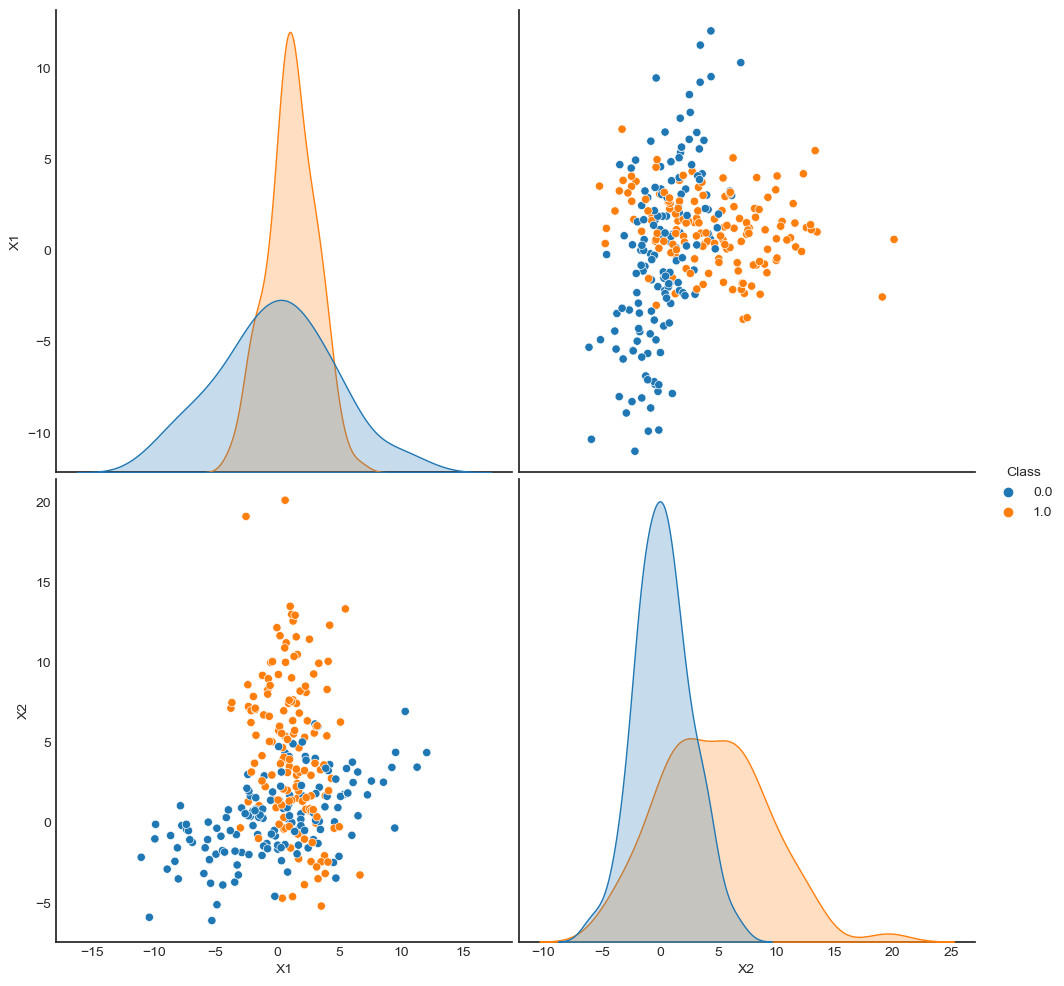

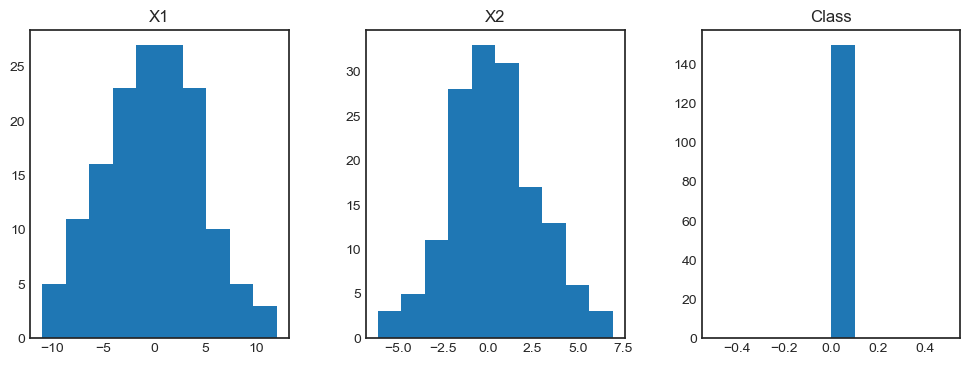

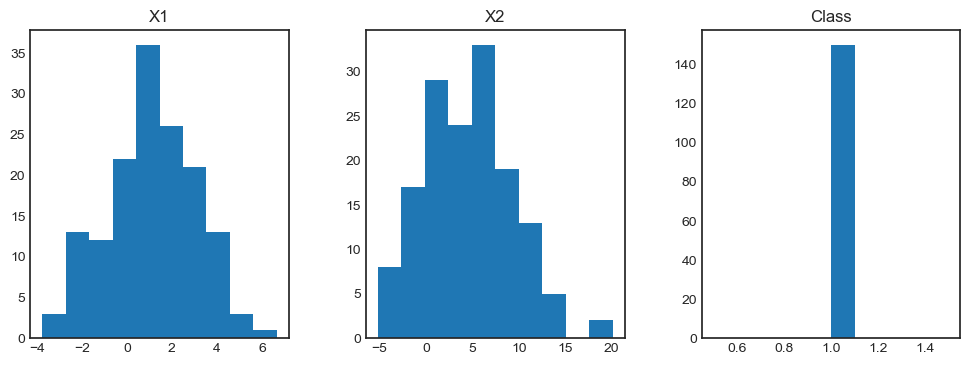

In [107]:

randstate = 42

#load the data
c3_df = pd.read_csv('c3_data.csv', header=0, names=['X1','X2','Class'], index_col=0)

#split test & nontest
c3_non_test_df,c3_test_df = train_test_split(c3_df,test_size=0.5,random_state=randstate, stratify=c3_df.Class)
#explore the non-test data
data_explore(c3_non_test_df)

In [108]:
#subset the training data into features and labels
X = c3_non_test_df.loc[:,['X1','X2']]
y = c3_non_test_df.loc[:,['Class']].values.ravel()

#instantiate qda model
qda = QuadraticDiscriminantAnalysis()
# qda = LinearDiscriminantAnalysis()
qda.fit(X, y)

kfold_count = 5

non_test_cv_precision=np.mean(cross_val_score(estimator = QuadraticDiscriminantAnalysis(), scoring=make_scorer(precision_score),
                                    X=X,
                                    y=y,
                                    cv=kfold_count))

print("Non-test set cv precision:",non_test_cv_precision)


#obtain prediction probs on test set using the model fit previously on the non-test data
preds_test = qda.predict_proba(c3_test_df.loc[:,['X1','X2']])

#classify the prediction probabilities
desired_precision = 1.0
y_hat_test = (preds_test[:,1]>=desired_precision)*1.0

predPos = y_hat_test==1 
truePos = predPos&(c3_test_df['Class'].values==1)
prec = sum(truePos*1.0)/sum(predPos*1.0)
print("precision:", prec) 
print("Test Set predicted positives:",sum(truePos*1.0))



Non-test set cv precision: 0.8356178660049627
precision: nan
Test Set predicted positives: 0.0


C:\Users\codeh\AppData\Local\Temp\ipykernel_6196\996735559.py:29: RuntimeWarning: invalid value encountered in double_scalars
  prec = sum(truePos*1.0)/sum(predPos*1.0)


## CASE 3 Diagnostics (STUDENT CODE REQUIRED)

So we can see that the novice's model seems to be unacceptably low precision during CV on the non-test set, but on the test set, the model is not predicting *anything* positive and precision cannot even be computed due to the divide by zero error!  This is bad.  Run diagnostics in the cell below to see if you can discover the problem



No Skill: ROC AUC=0.500
QDA: ROC AUC=0.911


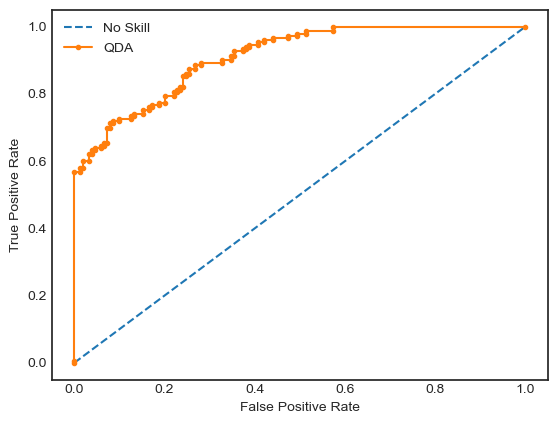

In [109]:
#CASE 3 DIAGNOSTICS


# --------- START STUDENT CODE -------------
X_non_test = c3_non_test_df.loc[:,['X1','X2']].values
y_non_test = c3_non_test_df.Class.values

X_test = c3_test_df.loc[:,['X1','X2']].values
y_test = c3_test_df.Class.values

qda.fit(X_non_test, y_non_test)

# predict probabilities
qda_probs = qda.predict_proba(X_test)

# keep probabilities for the positive outcome only
qda_probs = qda_probs[:, 1]

# get false pos rate, true pos rate and thresholds
fpr, tpr, thresholds = roc_curve(y_test, qda_probs)

# default threshold is .5 which does not provide perfect precision
# plot to see ROC curve for this data
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
qda_auc = roc_auc_score(y_test, qda_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('QDA: ROC AUC=%.3f' % (qda_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
qda_fpr, qda_tpr, _ = roc_curve(y_test, qda_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(qda_fpr, qda_tpr, marker='.', label='QDA')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


# --------- END STUDENT CODE -------------



## CASE 3 Explanation and Plan for Solution (STUDENT MARKDOWN REQURIED) 

Describe what you discovered in the diagnostic code you wrote above AND define the plan for how to resolve the issue

<font color='green'>STUDENT ANSWER BELOW</font>   

<font color='green'> The model provides reasonable performance with a AUC of .911, but the threshold for precision needs to be adjusted higher than the default .5. As the threshold increases, precision increases but the recall decreases. Since the goal of the customer is to maximize precision, I advise using the same model but adjust the threshold. I will use the true postive rate and thresholds produced by the roc_curve function and serach for the threshold that provides the precision the customer desires. This threshold should then be provided along with the model to the customer.
    

## CASE 3 Solution (STUDENT CODE REQURIRED)

In the code cell below, implement a solution which achieves the customer goal of perfect precision with the most possible targets found (maximize true positives).  

### Report the precision and number of true positives found in the test set.

In [70]:
# CASE 3 SOLUTION


test_prec = None #placeholder for test set precision
test_TP =None #placeholder for test set TRUE POSITIVE count (an integer)

X_non_test = c3_non_test_df.loc[:,['X1','X2']].values
y_non_test = c3_non_test_df.Class.values

X_test = c3_test_df.loc[:,['X1','X2']].values
y_test = c3_test_df.Class.values

clf = QuadraticDiscriminantAnalysis()  #you will need to train a model of this type

# --------- START STUDENT CODE -------------

clf.fit(X_non_test, y_non_test)

# predict probabilities
yhat = clf.predict_proba(X_test)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# get false pos rate, true pos rate and thresholds
fpr, tpr, thresholds = roc_curve(y_test, yhat)

#obtain prediction probs on test set using the model fit previously on the non-test data
preds_test = qda.predict_proba(c3_test_df.loc[:,['X1','X2']])

# place holder
threshold_perfect_precision = 0

#classify the prediction probabilities
for idx, thld in enumerate(thresholds):
    y_hat_test = (preds_test[:,1]>=thld)*1.0
    predPos = y_hat_test==1 
    truePos = predPos&(c3_test_df['Class'].values==1)
    prec = sum(truePos*1.0)/sum(predPos*1.0)
    if prec == 1:
        print(f'Found a perfect precision threshold!-> {thld} at idx {idx}')
        threshold_1 = thld

print(f'Using threshold {threshold_1}')

y_hat_test = (preds_test[:,1]>=threshold_1)*1.0
predPos = y_hat_test==1 
test_TP = predPos&(c3_test_df['Class'].values==1)
test_prec = sum(test_TP*1.0)/sum(predPos*1.0)

print(f'Test precision: {test_prec}') 
print(f'Test Set predicted positives: {sum(test_TP*1.0)}')

# --------- END STUDENT CODE -------------


Found a perfect precision threshold!-> 0.9999999999964024 at idx 1
Found a perfect precision threshold!-> 0.7956770756900668 at idx 2
Using threshold 0.7956770756900668
Test precision: 1.0
Test Set predicted positives: 85.0


C:\Users\codeh\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(
C:\Users\codeh\AppData\Local\Temp\ipykernel_6196\2119626491.py:39: RuntimeWarning: invalid value encountered in double_scalars
  prec = sum(truePos*1.0)/sum(predPos*1.0)


In [48]:


print("Test Set Precision:", test_prec, "; Test Set True Positives:", test_TP)


Test Set Precision: 1.0 ; Test Set True Positives: [ True  True False False False False  True  True False False False  True
 False  True False False  True False False False False False False False
 False False False False  True False False  True False  True False  True
 False  True False  True False False False False False False False False
 False False False  True  True False  True False False False  True  True
 False  True False False False False False False  True False  True False
 False False False  True  True False False False False False False  True
 False False False False False False  True False  True False False  True
 False False False  True  True False False False False  True False False
 False  True  True  True  True  True False False  True  True  True False
 False False False  True  True False  True False  True False False False
 False False False False  True False False False  True False False  True
 False False False  True False  True False False False False  True False
